In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [2]:
from google.colab import files
uploaded = files.upload()

Saving PM_train.txt to PM_train.txt


In [3]:
train_df = pd.read_csv('PM_train.txt', sep=" ", header=None).iloc[:, :26]
train_df.columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3'] + [f's{i}' for i in range(1, 22)]


In [4]:
train_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


In [5]:
up=files.upload()

Saving PM_test.txt to PM_test.txt


In [6]:
test_df = pd.read_csv('PM_test.txt', sep=" ", header=None).iloc[:, :26]
test_df.columns = train_df.columns

In [7]:
test_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,521.72,2388.03,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,522.16,2388.06,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,...,521.97,2388.03,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,...,521.38,2388.05,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,...,522.15,2388.03,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130


In [8]:
upload=files.upload()

Saving PM_truth.txt to PM_truth.txt


In [9]:
truth_df = pd.read_csv('PM_truth.txt', sep=" ", header=None).iloc[:, :1]

In [10]:
truth_df.head()

,0
0,112
1,98
2,69
3,82
4,91


In [11]:
train_df['RUL'] = train_df.groupby('id')['cycle'].transform('max') - train_df['cycle']
train_df

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s13,s14,s15,s16,s17,s18,s19,s20,s21,RUL
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100,196,-0.0004,-0.0003,100.0,518.67,643.49,1597.98,1428.63,14.62,...,2388.26,8137.60,8.4956,0.03,397,2388,100.0,38.49,22.9735,4
20627,100,197,-0.0016,-0.0005,100.0,518.67,643.54,1604.50,1433.58,14.62,...,2388.22,8136.50,8.5139,0.03,395,2388,100.0,38.30,23.1594,3
20628,100,198,0.0004,0.0000,100.0,518.67,643.42,1602.46,1428.18,14.62,...,2388.24,8141.05,8.5646,0.03,398,2388,100.0,38.44,22.9333,2
20629,100,199,-0.0011,0.0003,100.0,518.67,643.23,1605.26,1426.53,14.62,...,2388.23,8139.29,8.5389,0.03,395,2388,100.0,38.29,23.0640,1


In [12]:
scaler = MinMaxScaler()
train_df.iloc[:, 2:25] = scaler.fit_transform(train_df.iloc[:, 2:25])
train_df.head()

<ipython-input-12-a507ba427244>:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.33333333 0.33333333 0.16666667 ... 0.83333333 0.58333333 0.66666667]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  train_df.iloc[:, 2:25] = scaler.fit_transform(train_df.iloc[:, 2:25])


,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s13,s14,s15,s16,s17,s18,s19,s20,s21,RUL
0,1,1,0.459770,0.166667,0.0,0.0,0.183735,0.406802,0.309757,0.0,...,0.205882,0.199608,0.363986,0.0,0.333333,0,0.0,0.713178,23.4190,191
1,1,2,0.609195,0.250000,0.0,0.0,0.283133,0.453019,0.352633,0.0,...,0.279412,0.162813,0.411312,0.0,0.333333,0,0.0,0.666667,23.4236,190
2,1,3,0.252874,0.750000,0.0,0.0,0.343373,0.369523,0.370527,0.0,...,0.220588,0.171793,0.357445,0.0,0.166667,0,0.0,0.627907,23.3442,189
3,1,4,0.540230,0.500000,0.0,0.0,0.343373,0.256159,0.331195,0.0,...,0.294118,0.174889,0.166603,0.0,0.333333,0,0.0,0.573643,23.3739,188
4,1,5,0.390805,0.333333,0.0,0.0,0.349398,0.257467,0.404625,0.0,...,0.235294,0.174734,0.402078,0.0,0.416667,0,0.0,0.589147,23.4044,187


In [13]:
test_df['max_cycle'] = test_df.groupby('id')['cycle'].transform('max')
truth_df['id'] = truth_df.index + 1
truth_df.columns = ['RUL','id']
test_df = test_df.merge(truth_df, on='id', how='left')
test_df['RUL'] = test_df['RUL'] + (test_df['max_cycle'] - test_df['cycle'])
test_df.drop('max_cycle', axis=1, inplace=True)
test_df.iloc[:, 2:25] = scaler.transform(test_df.iloc[:, 2:25])


<ipython-input-13-ab430f6c385a>:7: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.33333333 0.41666667 0.41666667 ... 0.58333333 0.58333333 0.66666667]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  test_df.iloc[:, 2:25] = scaler.transform(test_df.iloc[:, 2:25])


In [14]:
test_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s13,s14,s15,s16,s17,s18,s19,s20,s21,RUL
0,1,1,0.632184,0.750000,0.0,0.0,0.545181,0.310661,0.269413,0.0,...,0.220588,0.132160,0.308965,0.0,0.333333,0,0.0,0.558140,23.3735,142
1,1,2,0.344828,0.250000,0.0,0.0,0.150602,0.379551,0.222316,0.0,...,0.264706,0.204768,0.213159,0.0,0.416667,0,0.0,0.682171,23.3916,141
2,1,3,0.517241,0.583333,0.0,0.0,0.376506,0.346632,0.322248,0.0,...,0.220588,0.155640,0.458638,0.0,0.416667,0,0.0,0.728682,23.4166,140
3,1,4,0.741379,0.500000,0.0,0.0,0.370482,0.285154,0.408001,0.0,...,0.250000,0.170090,0.257022,0.0,0.250000,0,0.0,0.666667,23.3737,139
4,1,5,0.580460,0.500000,0.0,0.0,0.391566,0.352082,0.332039,0.0,...,0.220588,0.152751,0.300885,0.0,0.166667,0,0.0,0.658915,23.4130,138


In [15]:
truth_df.head()

,RUL,id
0,112,1
1,98,2
2,69,3
3,82,4
4,91,5


In [16]:
train_df.corr()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s13,s14,s15,s16,s17,s18,s19,s20,s21,RUL
id,1.000000,0.078753,-0.017895,-0.006197,NaN,NaN,0.014133,0.012621,0.026116,NaN,...,0.044230,-0.059473,0.022486,NaN,0.013513,NaN,NaN,-0.020589,-0.016465,0.078753
cycle,0.078753,1.000000,-0.004527,0.016132,NaN,NaN,0.549898,0.543947,0.624577,NaN,...,0.477523,0.370324,0.588676,NaN,0.566995,NaN,NaN,-0.583597,-0.585923,-0.736241
setting1,-0.017895,-0.004527,1.000000,0.011660,NaN,NaN,0.009030,-0.005651,0.009544,NaN,...,0.002318,-0.004469,0.007652,NaN,0.002599,NaN,NaN,-0.005713,-0.014559,-0.003198
setting2,-0.006197,0.016132,0.011660,1.000000,NaN,NaN,0.007266,0.009068,0.014673,NaN,...,0.018156,-0.006310,0.014156,NaN,0.012280,NaN,NaN,-0.010554,-0.007846,-0.001948
setting3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
s1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
s2,0.014133,0.549898,0.009030,0.007266,NaN,NaN,1.000000,0.602610,0.714949,NaN,...,0.661792,0.179752,0.675975,NaN,0.629886,NaN,NaN,-0.661841,-0.668050,-0.606484
s3,0.012621,0.543947,-0.005651,0.009068,NaN,NaN,0.602610,1.000000,0.678413,NaN,...,0.600963,0.237137,0.639921,NaN,0.600017,NaN,NaN,-0.625941,-0.633901,-0.584520
s4,0.026116,0.624577,0.009544,0.014673,NaN,NaN,0.714949,0.678413,1.000000,NaN,...,0.745158,0.190748,0.758459,NaN,0.703499,NaN,NaN,-0.748067,-0.745193,-0.678948
s5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


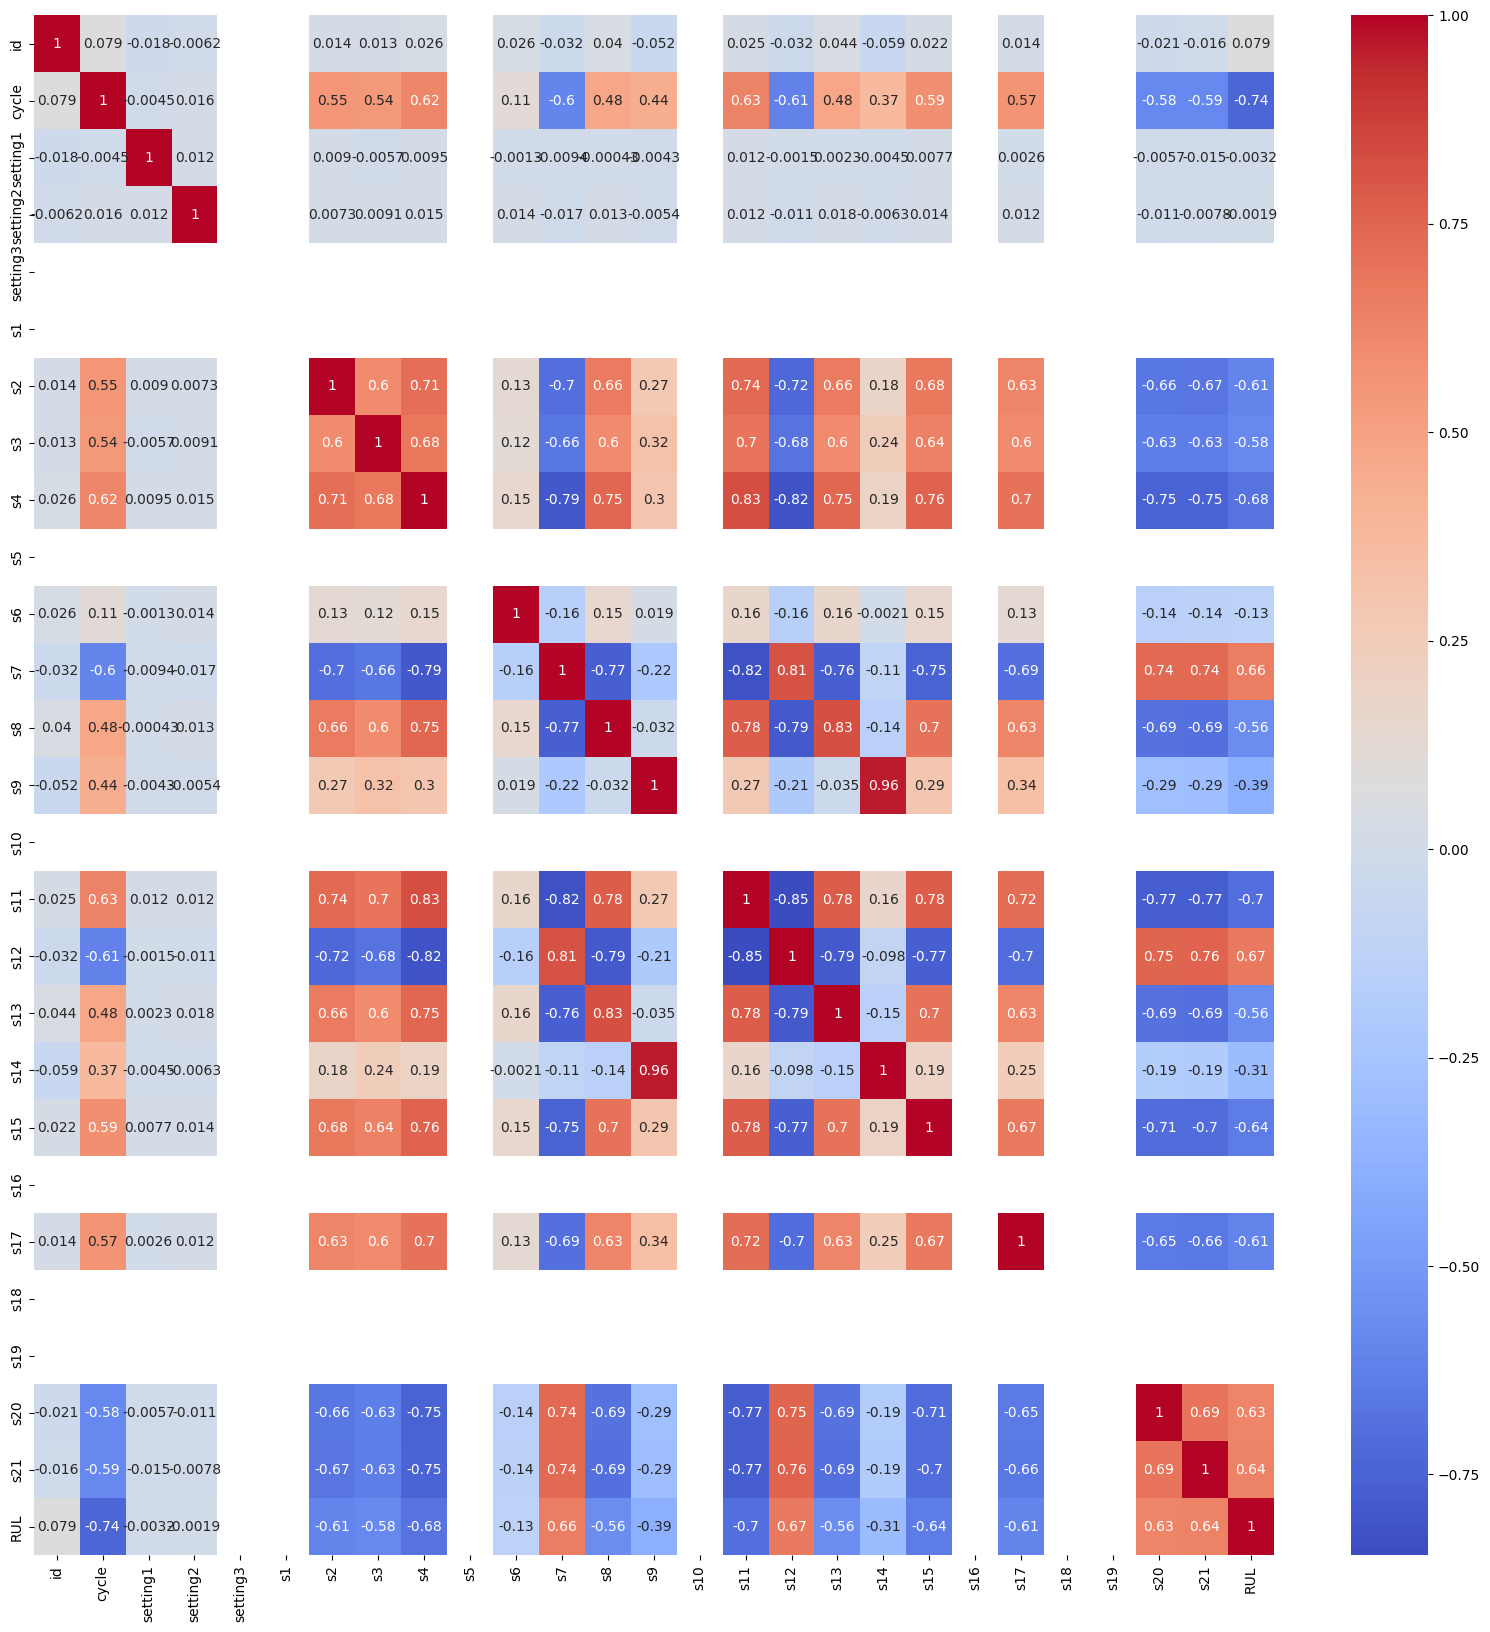

In [17]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(20, 20))
sns.heatmap(train_df.corr(), annot=True, cmap='coolwarm', ax=ax)
plt.show()

In [18]:
sequence_cols = ['cycle'] + [f's{i}' for i in range(1, 22)]
seq_length = 50

In [19]:
X_train = []
y_train = []

for id in train_df['id'].unique():
    id_data = train_df[train_df['id'] == id][sequence_cols].values
    for i in range(len(id_data) - seq_length):
        X_train.append(id_data[i:i + seq_length])
        y_train.append(train_df[train_df['id'] == id]['RUL'].iloc[i + seq_length])

X_train = np.array(X_train)
y_train = np.array(y_train)

In [20]:
X_train

array([[[1.00000000e+00, 0.00000000e+00, 1.83734940e-01, ...,
         0.00000000e+00, 7.13178295e-01, 2.34190000e+01],
        [2.00000000e+00, 0.00000000e+00, 2.83132530e-01, ...,
         0.00000000e+00, 6.66666667e-01, 2.34236000e+01],
        [3.00000000e+00, 0.00000000e+00, 3.43373494e-01, ...,
         0.00000000e+00, 6.27906977e-01, 2.33442000e+01],
        ...,
        [4.80000000e+01, 0.00000000e+00, 2.04819277e-01, ...,
         0.00000000e+00, 6.20155039e-01, 2.33650000e+01],
        [4.90000000e+01, 0.00000000e+00, 3.07228916e-01, ...,
         0.00000000e+00, 7.13178295e-01, 2.34498000e+01],
        [5.00000000e+01, 0.00000000e+00, 4.69879518e-01, ...,
         0.00000000e+00, 5.50387597e-01, 2.34106000e+01]],

       [[2.00000000e+00, 0.00000000e+00, 2.83132530e-01, ...,
         0.00000000e+00, 6.66666667e-01, 2.34236000e+01],
        [3.00000000e+00, 0.00000000e+00, 3.43373494e-01, ...,
         0.00000000e+00, 6.27906977e-01, 2.33442000e+01],
        [4.00000000e+00, 

In [21]:
y_train

array([141, 140, 139, ...,   2,   1,   0])

In [22]:
X_test = []
y_test = []

for id in test_df['id'].unique():
    id_data = test_df[test_df['id'] == id][sequence_cols].values
    for i in range(len(id_data) - seq_length):
        X_test.append(id_data[i:i + seq_length])
        y_test.append(test_df[test_df['id'] == id]['RUL'].iloc[i + seq_length])

X_test = np.array(X_test)
y_test = np.array(y_test)

In [23]:
model = Sequential([
    LSTM(100, input_shape=(seq_length, len(sequence_cols)), return_sequences=True),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(1)
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [24]:
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

In [25]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10),
    ModelCheckpoint('best_model.keras', save_best_only=True)
]

history = model.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=10,
    batch_size=64,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 28s 108ms/step - loss: 8966.0361 - mae: 76.3735 - val_loss: 10050.4746 - val_mae: 78.4310
Epoch 2/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 40s 104ms/step - loss: 6948.6953 - mae: 64.5152 - val_loss: 8611.7480 - val_mae: 71.2460
Epoch 3/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 41s 105ms/step - loss: 5800.0127 - mae: 58.2706 - val_loss: 7498.9629 - val_mae: 65.8211
Epoch 4/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 41s 104ms/step - loss: 5037.5269 - mae: 54.1844 - val_loss: 6643.2686 - val_mae: 61.7713
Epoch 5/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 23s 103ms/step - loss: 4359.9077 - mae: 50.4032 - val_loss: 5997.0249 - val_mae: 58.8001
Epoch 6/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 41s 105ms/step - loss: 3877.6128 - mae: 47.5119 - val_loss: 6015.2935 - val_mae: 58.1604
Epoch 7/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 41s 104ms/step - loss: 3326.9241 - mae: 42.5074 - val_loss: 5074.6162 - val_mae: 52.3472
Epoch 8/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 41s 104ms/step - loss: 2830.4089 - mae: 37.3391 - val_lo

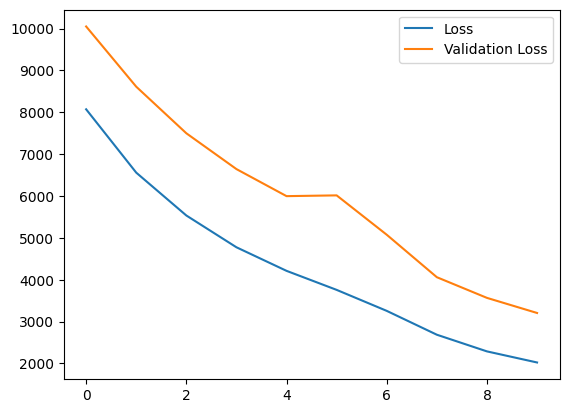

In [26]:
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

In [27]:
test_loss, test_mae = model.evaluate(X_test, y_test, verbose=1)
print(f'Test Loss: {test_loss}, Test MAE: {test_mae}')

256/256 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 3609.6851 - mae: 45.6360
Test Loss: 3292.11962890625, Test MAE: 43.28261947631836


In [28]:
y_pred = model.predict(X_test)

256/256 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step


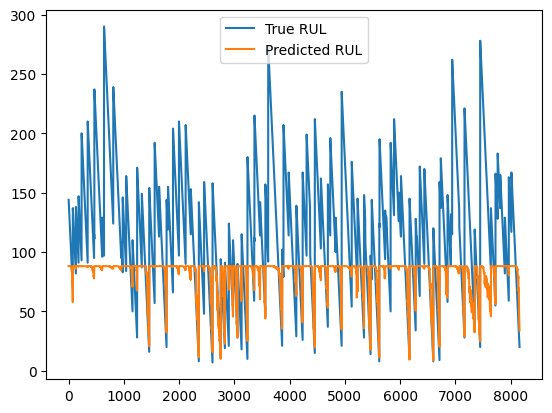

In [29]:
plt.plot(y_test, label='True RUL')
plt.plot(y_pred, label='Predicted RUL')
plt.legend()
plt.show()

# Classification Model


In [30]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, precision_score, recall_score
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
import matplotlib.pyplot as plt


In [31]:
train_data = pd.read_csv('PM_train.txt', sep=" ", header=None).iloc[:, :26]
test_data = pd.read_csv('PM_test.txt', sep=" ", header=None).iloc[:, :26]
truth_data = pd.read_csv('PM_truth.txt', sep=" ", header=None).iloc[:, :1]

In [32]:
columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3'] + [f's{i}' for i in range(1, 22)]
train_data.columns = columns
test_data.columns = columns

In [33]:
train_data.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


In [34]:
rul = train_data.groupby('id')['cycle'].max().reset_index()
rul.columns = ['id', 'max_cycle']
train_data = train_data.merge(rul, on='id', how='left')
train_data['RUL'] = train_data['max_cycle'] - train_data['cycle']
train_data.drop('max_cycle', axis=1, inplace=True)

In [35]:
train_data.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s13,s14,s15,s16,s17,s18,s19,s20,s21,RUL
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187


In [36]:
rul

,id,max_cycle
0,1,192
1,2,287
2,3,179
3,4,189
4,5,269
...,...,...
95,96,336
96,97,202
97,98,156
98,99,185


In [37]:
threshold = 30
train_data['label'] = (train_data['RUL'] <= threshold).astype(int)

In [38]:
train_data.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s14,s15,s16,s17,s18,s19,s20,s21,RUL,label
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191,0
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190,0
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189,0
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188,0
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187,0


In [39]:
scaler = MinMaxScaler()
features = columns[2:]
train_data[features] = scaler.fit_transform(train_data[features])
test_data[features] = scaler.transform(test_data[features])

In [40]:
train_data[features]

,setting1,setting2,setting3,s1,s2,s3,s4,s5,s6,s7,...,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
0,0.459770,0.166667,0.0,0.0,0.183735,0.406802,0.309757,0.0,1.0,0.726248,...,0.633262,0.205882,0.199608,0.363986,0.0,0.333333,0.0,0.0,0.713178,0.724662
1,0.609195,0.250000,0.0,0.0,0.283133,0.453019,0.352633,0.0,1.0,0.628019,...,0.765458,0.279412,0.162813,0.411312,0.0,0.333333,0.0,0.0,0.666667,0.731014
2,0.252874,0.750000,0.0,0.0,0.343373,0.369523,0.370527,0.0,1.0,0.710145,...,0.795309,0.220588,0.171793,0.357445,0.0,0.166667,0.0,0.0,0.627907,0.621375
3,0.540230,0.500000,0.0,0.0,0.343373,0.256159,0.331195,0.0,1.0,0.740741,...,0.889126,0.294118,0.174889,0.166603,0.0,0.333333,0.0,0.0,0.573643,0.662386
4,0.390805,0.333333,0.0,0.0,0.349398,0.257467,0.404625,0.0,1.0,0.668277,...,0.746269,0.235294,0.174734,0.402078,0.0,0.416667,0.0,0.0,0.589147,0.704502
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,0.477011,0.250000,0.0,0.0,0.686747,0.587312,0.782917,0.0,1.0,0.254428,...,0.170576,0.558824,0.194344,0.656791,0.0,0.750000,0.0,0.0,0.271318,0.109500
20627,0.408046,0.083333,0.0,0.0,0.701807,0.729453,0.866475,0.0,1.0,0.162641,...,0.211087,0.500000,0.188668,0.727203,0.0,0.583333,0.0,0.0,0.124031,0.366197
20628,0.522989,0.500000,0.0,0.0,0.665663,0.684979,0.775321,0.0,1.0,0.175523,...,0.281450,0.529412,0.212148,0.922278,0.0,0.833333,0.0,0.0,0.232558,0.053991
20629,0.436782,0.750000,0.0,0.0,0.608434,0.746021,0.747468,0.0,1.0,0.133655,...,0.208955,0.514706,0.203065,0.823394,0.0,0.583333,0.0,0.0,0.116279,0.234466


In [41]:
test_data[features]

,setting1,setting2,setting3,s1,s2,s3,s4,s5,s6,s7,...,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
0,0.632184,0.750000,0.0,0.0,0.545181,0.310661,0.269413,0.0,1.0,0.652174,...,0.646055,0.220588,0.132160,0.308965,0.0,0.333333,0.0,0.0,0.558140,0.661834
1,0.344828,0.250000,0.0,0.0,0.150602,0.379551,0.222316,0.0,1.0,0.805153,...,0.739872,0.264706,0.204768,0.213159,0.0,0.416667,0.0,0.0,0.682171,0.686827
2,0.517241,0.583333,0.0,0.0,0.376506,0.346632,0.322248,0.0,1.0,0.685990,...,0.699360,0.220588,0.155640,0.458638,0.0,0.416667,0.0,0.0,0.728682,0.721348
3,0.741379,0.500000,0.0,0.0,0.370482,0.285154,0.408001,0.0,1.0,0.679549,...,0.573561,0.250000,0.170090,0.257022,0.0,0.250000,0.0,0.0,0.666667,0.662110
4,0.580460,0.500000,0.0,0.0,0.391566,0.352082,0.332039,0.0,1.0,0.694042,...,0.737740,0.220588,0.152751,0.300885,0.0,0.166667,0.0,0.0,0.658915,0.716377
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13091,0.781609,0.500000,0.0,0.0,0.611446,0.619359,0.566172,0.0,1.0,0.573269,...,0.426439,0.176471,0.584890,0.564063,0.0,0.500000,0.0,0.0,0.395349,0.418669
13092,0.436782,0.416667,0.0,0.0,0.605422,0.537388,0.671843,0.0,1.0,0.542673,...,0.503198,0.308824,0.572350,0.485956,0.0,0.583333,0.0,0.0,0.333333,0.528721
13093,0.465517,0.250000,0.0,0.0,0.671687,0.482014,0.414754,0.0,1.0,0.513688,...,0.530917,0.235294,0.605326,0.507888,0.0,0.583333,0.0,0.0,0.372093,0.429301
13094,0.281609,0.583333,0.0,0.0,0.617470,0.522128,0.626435,0.0,1.0,0.566828,...,0.562900,0.294118,0.622046,0.562524,0.0,0.583333,0.0,0.0,0.403101,0.518779


In [42]:
sequence_length = 50

def create_sequences(data, seq_length, features):
    sequences = []
    labels = []
    for engine_id in data['id'].unique():
        engine_data = data[data['id'] == engine_id]
        for i in range(len(engine_data) - seq_length + 1):
            sequences.append(engine_data[features].iloc[i:i+seq_length].values)
            labels.append(engine_data['label'].iloc[i+seq_length-1])
    return np.array(sequences), np.array(labels)

train_sequences, train_labels = create_sequences(train_data, sequence_length, features)

In [43]:
train_sequences

array([[[0.45977011, 0.16666667, 0.        , ..., 0.        ,
         0.71317829, 0.7246617 ],
        [0.6091954 , 0.25      , 0.        , ..., 0.        ,
         0.66666667, 0.73101353],
        [0.25287356, 0.75      , 0.        , ..., 0.        ,
         0.62790698, 0.62137531],
        ...,
        [0.6091954 , 0.58333333, 0.        , ..., 0.        ,
         0.62015504, 0.65009666],
        [0.41954023, 0.91666667, 0.        , ..., 0.        ,
         0.71317829, 0.76719138],
        [0.31609195, 0.41666667, 0.        , ..., 0.        ,
         0.5503876 , 0.71306269]],

       [[0.6091954 , 0.25      , 0.        , ..., 0.        ,
         0.66666667, 0.73101353],
        [0.25287356, 0.75      , 0.        , ..., 0.        ,
         0.62790698, 0.62137531],
        [0.54022989, 0.5       , 0.        , ..., 0.        ,
         0.57364341, 0.66238608],
        ...,
        [0.41954023, 0.91666667, 0.        , ..., 0.        ,
         0.71317829, 0.76719138],
        [0.3

In [44]:
train_labels

array([0, 0, 0, ..., 1, 1, 1])

In [45]:
model = Sequential([
    LSTM(100, input_shape=(sequence_length, len(features)), return_sequences=True),
    Dropout(0.2),
    LSTM(50),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                        │ (None, 50, 100)             │          50,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 50, 100)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 50)                  │          30,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 80,251 (313.48 KB)

 Trainable params: 80,251 (313.48 KB)

 Non-trainable params: 0 (0.00 B)

In [46]:
history = model.fit(
    train_sequences, train_labels,
    epochs=20, batch_size=200, validation_split=0.2, verbose=1
)


Epoch 1/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 18s 245ms/step - accuracy: 0.8202 - loss: 0.3846 - val_accuracy: 0.9549 - val_loss: 0.0973
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 20s 240ms/step - accuracy: 0.9550 - loss: 0.1092 - val_accuracy: 0.9555 - val_loss: 0.1058
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 20s 234ms/step - accuracy: 0.9643 - loss: 0.0866 - val_accuracy: 0.9593 - val_loss: 0.0911
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 15s 239ms/step - accuracy: 0.9645 - loss: 0.0827 - val_accuracy: 0.9593 - val_loss: 0.0872
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 20s 236ms/step - accuracy: 0.9682 - loss: 0.0729 - val_accuracy: 0.9596 - val_loss: 0.0866
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 22s 253ms/step - accuracy: 0.9690 - loss: 0.0716 - val_accuracy: 0.9657 - val_loss: 0.0775
Epoch 7/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 19s 238ms/step - accuracy: 0.9665 - loss: 0.0788 - val_accuracy: 0.9584 - val_loss: 0.1016
Epoch 8/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 248ms/step - accuracy: 0.9700 - loss: 0.0716 - val_accu

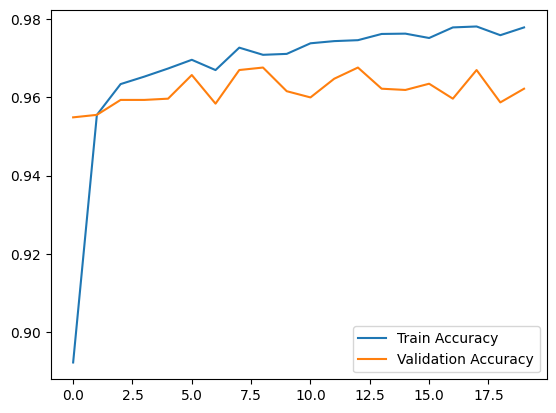

In [47]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()

In [48]:
train_predictions = (model.predict(train_sequences) > 0.5).astype(int)
from sklearn.metrics import precision_score, recall_score
print("Precision:", precision_score(train_labels, train_predictions))
print("Recall:", recall_score(train_labels, train_predictions))

492/492 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step
Precision: 0.9424368404221298
Recall: 0.9506451612903226


Confusion Matrix:


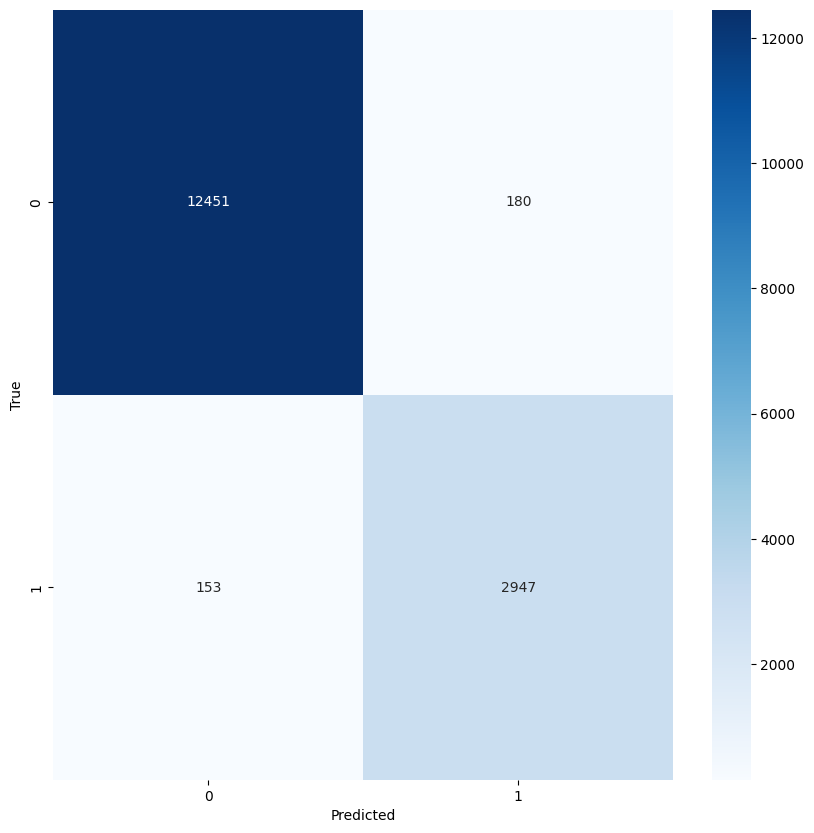

In [49]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
print("Confusion Matrix:")
confusion_matrix(train_labels, train_predictions)
fig=plt.figure(figsize=(10,10))
sns.heatmap(confusion_matrix(train_labels, train_predictions), annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()